# Dropout Predictor

Dropout Predictor aims to develop predictive models to determine student outcomes based on various features. By leveraging machine learning techniques, specifically neural networks, the models classify whether a student will drop out or graduate. Two models are implemented: a simple neural network and an optimized version incorporating regularization and early stopping to enhance performance and prevent overfitting.


The dataset used for this project is found on [Kaggle](https://www.kaggle.com/datasets/naveenkumar20bps1137/predict-students-dropout-and-academic-success?select=dataset.csv ). It contains various features related to student demographics, academic performance, and other relevant factors influencing enrollment outcomes. The target variable is `Target`, which indicates whether a student has enrolled (`Graduate`) or dropped out (`Dropout`).

In [30]:
# Import some important libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import pickle

In [2]:
# Loading the data

df = pd.read_csv("data/dataset.csv")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
print(df.columns)

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

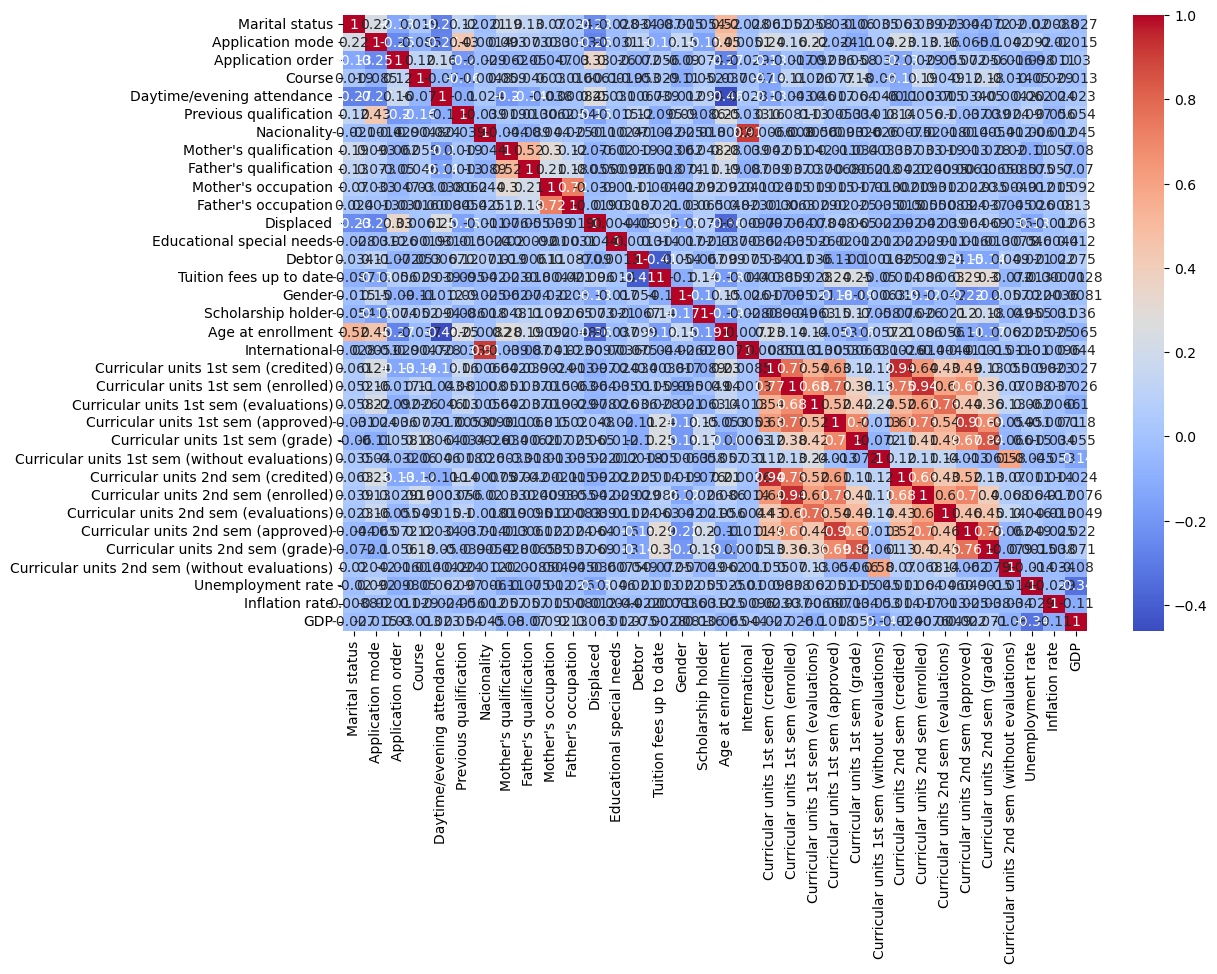

In [4]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# Now compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [5]:
df.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender                                              int64
Scholarship holder                                  int64
Age at enrollm

In [6]:
df.Target.value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

**Data Cleaning**: Instances labeled as `Enrolled` are going to be removed from Target Column in order to focus on the binary classification between `Dropout` and `Graduate`.

In [7]:
df=df[df.Target!='Enrolled']

In [8]:
df.Target.value_counts()

Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64

### Check if there are missing values

In [9]:
df.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [10]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,...,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,1.184298,6.810193,1.750138,9.935537,0.887603,2.552617,1.242424,12.558678,16.663636,7.212948,...,0.128926,0.581818,6.296419,7.763085,4.518457,10.036155,0.142149,11.630358,1.231598,-0.009256
std,0.613009,5.253618,1.333831,4.340715,0.315897,3.952440,1.700394,9.006183,10.993025,3.707343,...,0.679111,2.022688,2.263020,3.964163,3.162376,5.481742,0.747670,2.667652,1.384911,2.259986
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.517857,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,8.000000,1.000000,11.000000,1.000000,1.000000,1.000000,13.000000,14.000000,6.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,1.400000,0.320000
75%,1.000000,12.000000,2.000000,13.000000,1.000000,1.000000,1.000000,22.000000,27.000000,10.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000
max,6.000000,18.000000,6.000000,17.000000,1.000000,17.000000,21.000000,29.000000,34.000000,32.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [11]:
print(df.Target)

0        Dropout
1       Graduate
2        Dropout
3       Graduate
4       Graduate
          ...   
4419    Graduate
4420     Dropout
4421     Dropout
4422    Graduate
4423    Graduate
Name: Target, Length: 3630, dtype: object


**Encoding Categorical Variables**: The `LabelEncoder` is going to transforms the target variable into binary form (0 for 'Dropout', 1 for 'Graduate').

In [12]:
encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])

In [13]:
print(df.Target)

0       0
1       1
2       0
3       1
4       1
       ..
4419    1
4420    0
4421    0
4422    1
4423    1
Name: Target, Length: 3630, dtype: int64


In [14]:
df.Target.value_counts()

Target
1    2209
0    1421
Name: count, dtype: int64

In [15]:
X = df.drop(columns=['Target'])
Y = df['Target']

In [16]:
# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

## Model 1 Definition

In [17]:
# Simple Neural Network Model (no optimizations)
model1 = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer 1
    Dense(32, activation='relu'),  # Hidden layer 2
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/elvis-guy/anaconda3/envs/runpython/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
history1 = model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1000, verbose=0)

loss, accuracy = model1.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8464 - loss: 2.0509 
Test Loss: 2.1766600608825684
Test Accuracy: 0.85537189245224


In [19]:
with open('saved_models/model1.pkl', 'wb') as file:
    pickle.dump(model1, file)

## Model 2 Definition

In [20]:

# Model with Optimizations L1, L2, Early stopping
model2 = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
history2 = model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1000, verbose=0, callbacks=[early_stopping])

loss2, accuracy2 = model2.evaluate(X_test, Y_test)
print("Test Loss:", loss2)
print("Test Accuracy:", accuracy2)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9201 - loss: 0.2788 
Test Loss: 0.2767581045627594
Test Accuracy: 0.918732762336731


In [23]:
with open('saved_models/model2.pkl', 'wb') as file:
    pickle.dump(model2, file)

In [24]:
# Load the model 1 from saved_models folder
with open('saved_models/model1.pkl', 'rb') as file:
    loaded_model1 = pickle.load(file)

In [25]:
# Load the model2 from saved_models folder
with open('saved_models/model2.pkl', 'rb') as file:
    loaded_model2 = pickle.load(file)

## Error Analysis

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [27]:
def evaluate_model(model, X_test, Y_test, model_name="Model"):
    """
    Evaluates the model and prints confusion matrix, specificity, F1 score, and classification report.
    """
    # Predict probabilities
    Y_pred_prob = model.predict(X_test)
    # Convert probabilities to binary predictions
    Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()
    
    # Compute confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    print(f"\n{model_name} - Confusion Matrix:")
    plot_confusion_matrix(cm, classes=['Dropout', 'Graduate'], title=f'{model_name} - Confusion Matrix')
    
    # Extract TN, FP, FN, TP
    TN, FP, FN, TP = cm.ravel()
    
    # Compute Specificity: TN / (TN + FP)
    specificity = TN / (TN + FP)
    print(f"{model_name} - Specificity: {specificity:.4f}")
    
    # Compute F1 Score
    f1 = f1_score(Y_test, Y_pred)
    print(f"{model_name} - F1 Score: {f1:.4f}")
    
    # Optional: Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(Y_test, Y_pred, target_names=['Dropout', 'Graduate']))
    
    return {
        'Confusion Matrix': cm,
        'Specificity': specificity,
        'F1 Score': f1
    }

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Model 1 - Confusion Matrix:
Confusion Matrix, without normalization


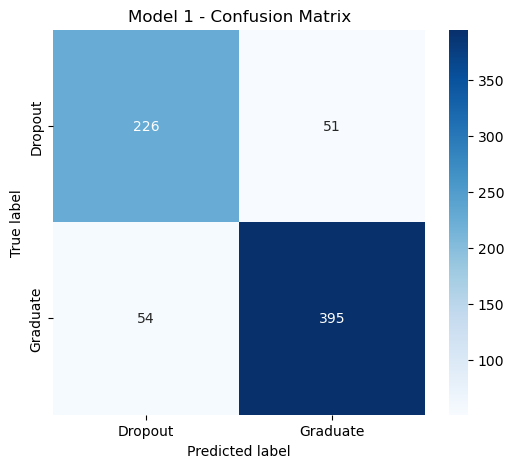

Model 1 - Specificity: 0.8159
Model 1 - F1 Score: 0.8827

Model 1 - Classification Report:
              precision    recall  f1-score   support

     Dropout       0.81      0.82      0.81       277
    Graduate       0.89      0.88      0.88       449

    accuracy                           0.86       726
   macro avg       0.85      0.85      0.85       726
weighted avg       0.86      0.86      0.86       726

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Model 2 - Confusion Matrix:
Confusion Matrix, without normalization


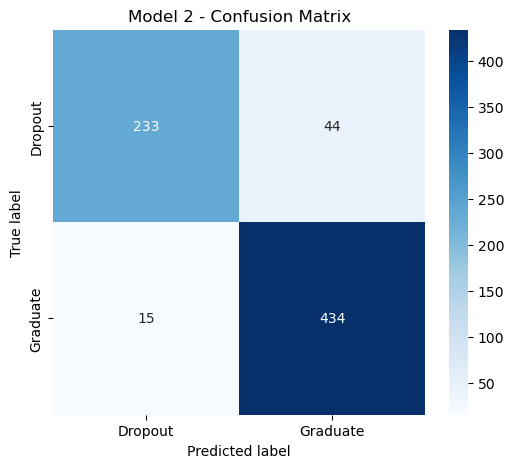

Model 2 - Specificity: 0.8412
Model 2 - F1 Score: 0.9364

Model 2 - Classification Report:
              precision    recall  f1-score   support

     Dropout       0.94      0.84      0.89       277
    Graduate       0.91      0.97      0.94       449

    accuracy                           0.92       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.92      0.92       726



In [28]:
# Evaluate Model 1
results_model1 = evaluate_model(loaded_model1, X_test, Y_test, model_name="Model 1")

# Evaluate Model 2
results_model2 = evaluate_model(loaded_model2, X_test, Y_test, model_name="Model 2")

In [29]:
# Create a summary DataFrame
summary = pd.DataFrame({
    'Model': ['Model 1', 'Model 2'],
    'Test Loss': [loss, loss2],
    'Test Accuracy': [accuracy, accuracy2],
    'Specificity': [results_model1['Specificity'], results_model2['Specificity']],
    'F1 Score': [results_model1['F1 Score'], results_model2['F1 Score']]
})

print("\nModel Performance Summary:")
print(summary)


Model Performance Summary:
     Model  Test Loss  Test Accuracy  Specificity  F1 Score
0  Model 1   2.176660       0.855372     0.815884  0.882682
1  Model 2   0.276758       0.918733     0.841155  0.936354
